# Hessian matrix

In [1]:
# Cookbook specifics imports
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import qmc
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, minmax_scale

In [2]:
def sample_sobol(n, d):
    sampler = qmc.Sobol(d, scramble=False)
    samples = sampler.random_base2(int(np.log2(n)))
    return samples


def sample_random(n, d):
    return np.random.rand(n, d)


def likelihood(X):
    # ellipsoid parameters
    # (short and long axes)
    a, b = 1, 2
    # center
    x0, y0 = 0.5, 0.5
    # angle
    alpha = 3 * np.pi / 4
    x = X[:, 0]
    y = X[:, 1]
    return 0.7 - 0.3 * (
        (1 / a**2) * ((x - x0) * np.cos(alpha) + (y - y0) * np.sin(alpha)) ** 2
        + (1 / b**2) * ((y - y0) * np.cos(alpha) + (x - x0) * np.sin(alpha)) ** 2
    )


def humps(X):
    scaling_factor = 1e-2
    x = X[:, 0]
    y = X[:, 1]
    return scaling_factor * np.cos(10 * x) * np.sin(10 * y)


def noise():
    noise_level = 1e-2
    return noise_level * np.random.rand(
        N,
    )


def sample_order(X, centroid):
    distance_to_centroid = np.linalg.norm(X - centroid, ord=2, axis=1)
    return np.argsort(distance_to_centroid)


dim = 4
N = 256

samples = sample_sobol(N, dim)
likelihood_values = likelihood(samples) + humps(samples) + noise()
centroid = [0.5, 0.5, 0.5, 0.5]
x_order = sample_order(samples, centroid)

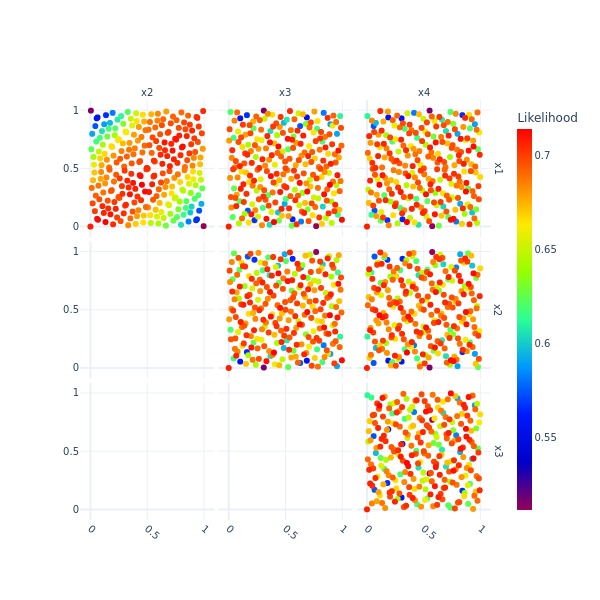

In [5]:
# Data sorted on ascending likelihood will yield prettier scatter plots
# where high likelihood values will be on top of low ones
likelihood_argsort = np.argsort(likelihood_values)
likelihood_sorted = likelihood_values[likelihood_argsort]
x_sorted = samples[likelihood_argsort, :]

fig = make_subplots(
    dim - 1,
    dim - 1,
    shared_xaxes=True,
    shared_yaxes=True,
    horizontal_spacing=0.01,
    vertical_spacing=0.01,
    column_titles=[f"x{j+1}" for j in range(1, dim)],
    row_titles=[f"x{i+1}" for i in range(0, dim - 1)],
)
for i in range(0, dim - 1):
    for j in range(1, dim):
        if i < j:
            fig.add_trace(
                go.Scatter(
                    x=x_sorted[:, j],
                    y=x_sorted[:, i],
                    mode="markers",
                    marker=dict(
                        size=6,
                        color=likelihood_sorted,
                        coloraxis="coloraxis1",
                    ),
                    hoverinfo="none",
                ),
                row=i + 1,
                col=j,
            )
        else:
            fig.add_trace(go.Scatter(x=[], y=[]), row=i + 1, col=j)
fig.update_annotations(font_size=10)
fig.update_xaxes(tickangle=40)
fig.update_coloraxes(
    colorbar_title="Likelihood",
    cmin=likelihood_sorted[-1],
    cmax=likelihood_sorted[0],
    colorscale="Rainbow",
    colorbar_thickness=15,
)
fig.update_layout(
    font=dict(size=10),
    showlegend=False,
    width=600,
    height=600,
    template="plotly_white",
)
fig.show(renderer="jpeg")

In [6]:
def fit_quadratic_model(X, y):
    poly_reg = PolynomialFeatures(degree=2)
    quadratic_monomials = poly_reg.fit_transform(X)

    regressor = LinearRegression(
        fit_intercept=False
    )  # intercept is already accounted for by quadratic_monomials
    regressor.fit(quadratic_monomials, y)
    r2_score = regressor.score(quadratic_monomials, y)

    # assemble the Hessian matrix and gradient
    H = np.zeros((dim, dim))
    g = np.zeros((dim,))
    regressor_coefs = regressor.coef_.flatten()
    for r, row in enumerate(poly_reg.powers_):
        c = regressor_coefs[r]
        # print(f"row={row}, coef={c}")
        if np.sum(row) == 2:
            (nonzeros,) = np.nonzero(row)
            # print(f"row={row} has shape {row.shape}, nonzeros={nonzeros}")
            if len(nonzeros) == 1:
                i = nonzeros[0]
                # print(f"Adding {c:.1e} to position {nonzeros[0]},{nonzeros[0]}")
                H[i, i] += c
                g[i] += 2 * c * centroid[i]
            elif len(nonzeros) == 2:
                i, j = nonzeros[0], nonzeros[1]
                # print(f"Adding {c/2:.1e} to position {nonzeros[0]},{nonzeros[1]} and {nonzeros[1]},{nonzeros[0]}")
                H[i, j] += c / 2
                H[j, i] += c / 2
                g[i] += c * centroid[j]
                g[j] += c * centroid[i]
            else:
                print(f"Hey that's weird: {row}")
        elif np.sum(row) == 1:
            (nonzeros,) = np.nonzero(row)
            if len(nonzeros) == 1:
                i = nonzeros[0]
                g[i] += c
            else:
                print(f"Hey that's weird: {row}")
        else:  # degree 0 does not contribute to the Hessian
            continue
    return H, g, r2_score


H, gradient, r2_score = fit_quadratic_model(samples, likelihood_values)
eigen_decomposition = np.linalg.eig(H)
print(f"Hessian matrix:\n {H}")
print(f"Gradient:\n {gradient}")
print(f"Quadratic fit R2 score = {r2_score}")
h_df = pd.DataFrame(
    data=np.hstack(
        (
            np.reshape(eigen_decomposition.eigenvalues, (dim, 1)),
            eigen_decomposition.eigenvectors.T,
        )
    ),
    columns=["eigenValue"] + [f"x{k+1}" for k in range(dim)],
)
h_df = h_df.sort_values(by="eigenValue", ascending=True)
h_df

Hessian matrix:
 [[-0.19453151  0.18917474  0.00024805  0.00188091]
 [ 0.18917474 -0.19249291 -0.00063539  0.00077991]
 [ 0.00024805 -0.00063539 -0.01024173  0.00231003]
 [ 0.00188091  0.00077991  0.00231003 -0.00396608]]
Gradient:
 [-9.78457835e-04  3.71451911e-04 -1.69365379e-05  5.90793228e-04]
Quadratic fit R2 score = 0.9787252473863062


,eigenValue,x1,x2,x3,x4
0,-0.382692,-0.709013,0.705190,0.001662,0.002059
3,-0.011112,0.093067,0.092354,0.932668,-0.336064
2,-0.005476,-0.559262,-0.564543,0.301550,0.526863
1,-0.001951,0.419362,0.418889,0.197976,0.780687


In [7]:
# How many points (minimum) do we need to fit a quadratic model?
poly_reg = PolynomialFeatures(degree=2)
quadratic_monomials = poly_reg.fit_transform(samples)
min_n = quadratic_monomials.shape[1]
print(f"In dimension {dim}, one needs at least {min_n} points to fit a quadratic model")


n_vector = np.arange(min_n, N + 1, 1)
eigenvalues = []
r2_scores = []
gradients = []
for n in n_vector:
    x = samples[x_order[:n], :]
    y = likelihood_values[x_order[:n]]
    H, gradient, r2_score = fit_quadratic_model(x, y)
    eigen_decomposition = np.linalg.eig(H)
    eigenvalues.append(np.sort(eigen_decomposition.eigenvalues))
    r2_scores.append(r2_score)
    gradients.append(np.linalg.norm(gradient, ord=2))
eigenvalues = np.array(eigenvalues)

fig = go.Figure(
    go.Scatter(x=n_vector, y=eigenvalues[:, 0], name=f"lambda1", mode="lines")
)
for k in range(1, 4):
    fig.add_scatter(x=n_vector, y=eigenvalues[:, k], mode="lines", name=f"lambda{k+1}")
fig.update_layout(width=950, xaxis_title="n", yaxis_title="Hessian matrix eigen values")
fig.show()

fig = go.Figure(go.Scatter(x=n_vector, y=gradients, mode="lines"))
fig.update_layout(width=950, xaxis_title="n", yaxis_title="norm2(gradient)")
fig.show()

fig = go.Figure(go.Scatter(x=n_vector, y=r2_scores, mode="lines"))
fig.update_layout(width=950, xaxis_title="n", yaxis_title="quadratic fit r2 score")
fig.show()

In dimension 4, one needs at least 15 points to fit a quadratic model
